In [58]:
from muler.igrins import IGRINSSpectrum
from muler.hpf import HPFSpectrum
from specutils import Spectrum1D

from numba import jit

import numpy as np
import matplotlib.pyplot as plt
import requests

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False

In [59]:
path = 'A:/Documents/Grad_School/Research/igrins_reduced/20161101/'
filename = 'SDCK_20161101_0062.spec_a0v.fits'
spec = IGRINSSpectrum(file=path+filename)

# Downloading IGRINS data from Box, light post-processing, and quickly plotting it

In [60]:
URL = 'https://utexas.box.com/shared/static/'
download_dictionary = {'SDCK_20201202_0059.spec_a0v.fits':'verow76mp47nzk6m1t4y08xmwt0n6tlg.fits',
                       'SDCK_20201202_0059.sn.fits':'wl5roxf0zfgs3tnhqvnlkl9ixqp2xfve.fits'}



In [61]:
def download_file(filename, file_id):
    """Download the file from Google Drive"""
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : file_id }, stream = True)
    if response.status_code == 200: # Successfully found the file on Google Drive
        CHUNK_SIZE = 32768

        with open(filename, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
        print("Downloaded {}".format(filename))



In [62]:
for key, value in download_dictionary.items():
    download_file(key, value)

In [63]:
spectrum = IGRINSSpectrum(file='SDCK_20201202_0059.spec_a0v.fits', order=11).normalize()
# spectrum = IGRINSSpectrum(file='A:/Documents/Grad_School/Research/igrins_reduced/20181120/SDCK_20181120_0059.spec.fits',
#                            order=11,
#                            wavefile='A:/Documents/Grad_School/Research/igrins_reduced/20181120/SDCK_20181120_0059.wave.fits').normalize()
# A:\Documents\Grad_School\Research\igrins_reduced\20181120\SDCK_20181120_0059.spec.fits

The spectrum metadata appears to be missing.  The functionality of muler may be impaired without metadata.  See discussion at https://github.com/OttoStruve/muler/issues/79.


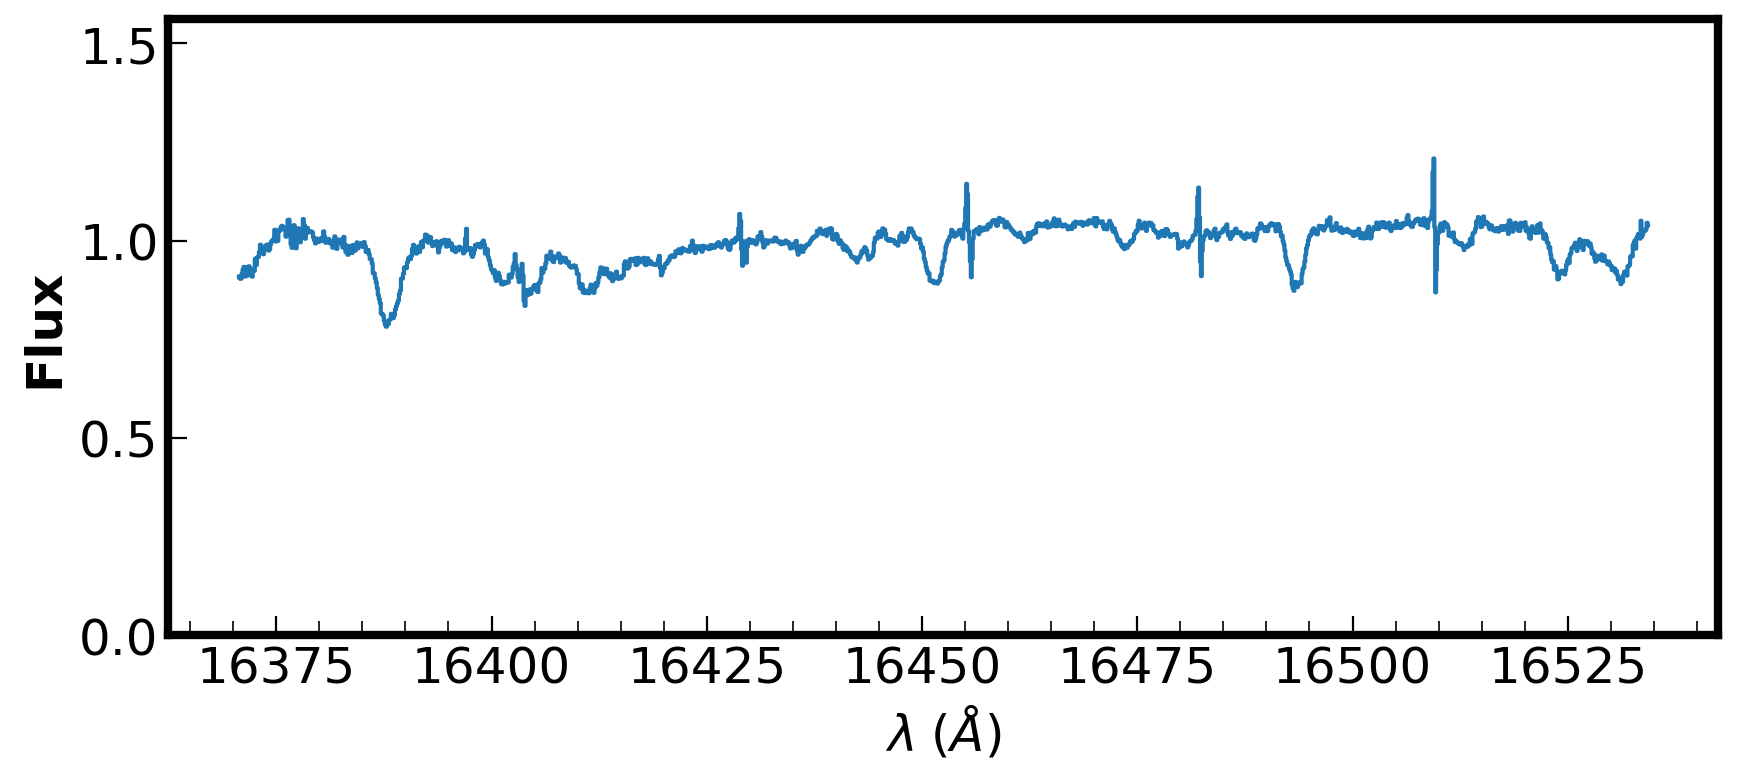

In [64]:
spectrum = spectrum.trim_edges().remove_nans()
# fig,ax = plt.subplots(figsize=(20,10))
spectrum.plot()
plt.show()

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import warnings

import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join
from astropy.wcs import WCS
from astropy.modeling import models, fitting

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.fitting import fit_lines
from specutils.analysis import equivalent_width


In [66]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Generic Spectra

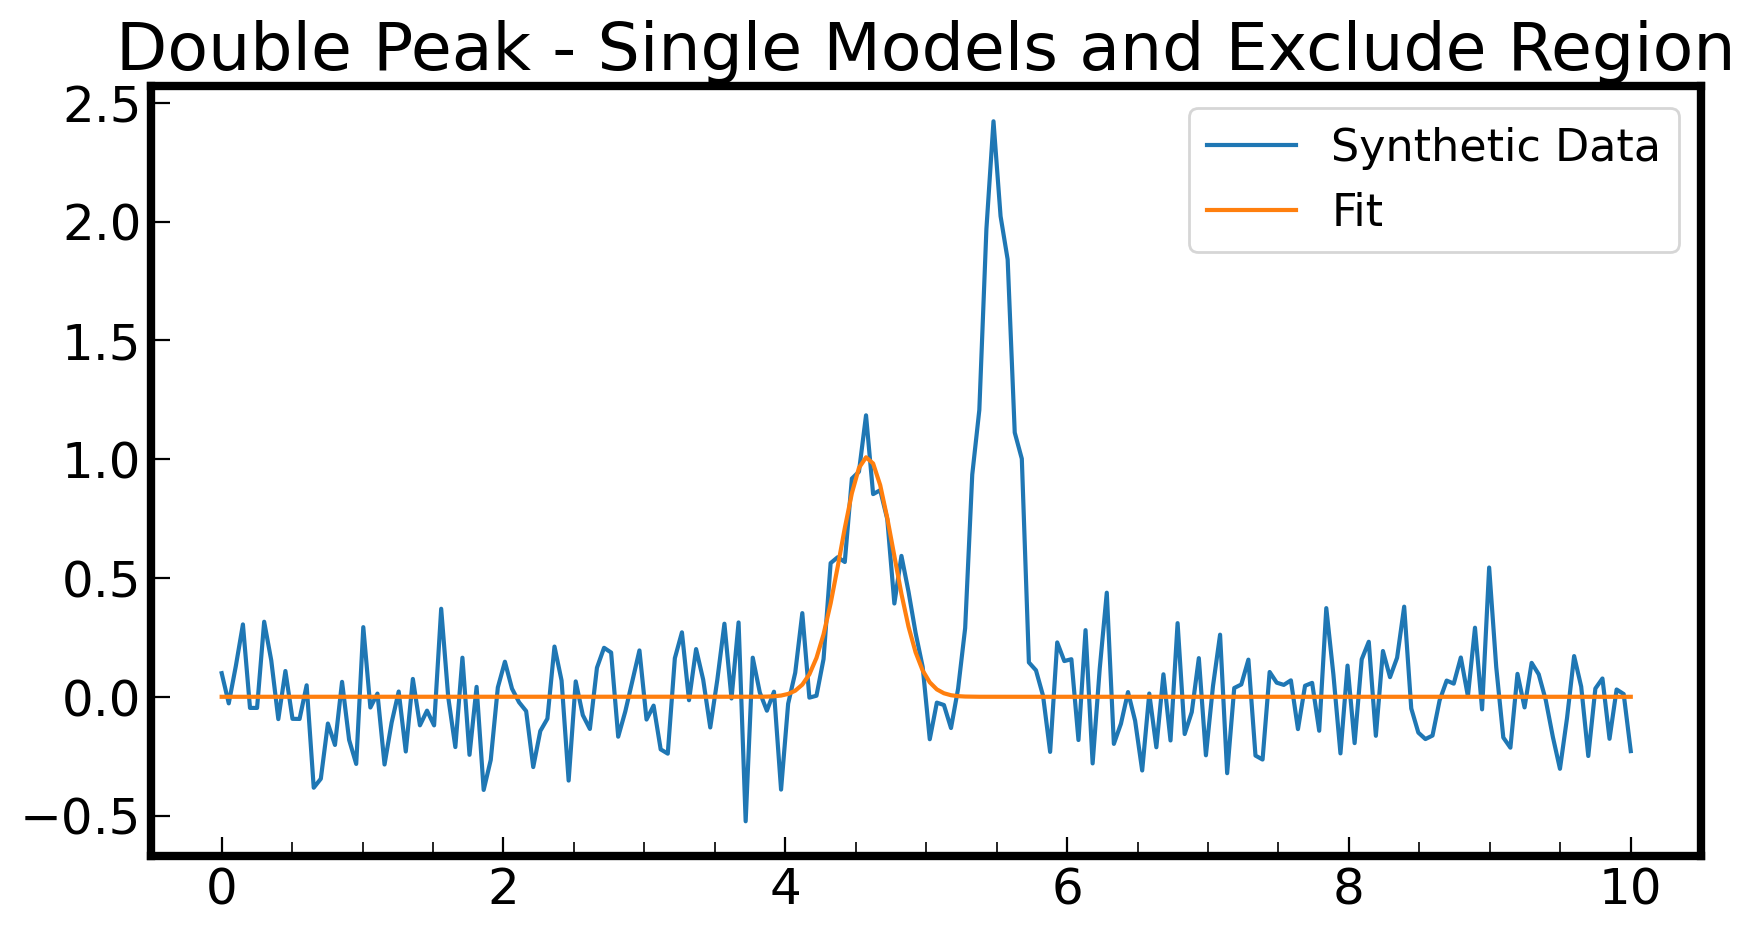

In [67]:
# Create a simple spectrum with a Gaussian.

np.random.seed(42)

g1 = models.Gaussian1D(1, 4.6, 0.2)

g2 = models.Gaussian1D(2.5, 5.5, 0.1)

x = np.linspace(0, 10, 200)

y = g1(x) + g2(x) + np.random.normal(0., 0.2, x.shape)

# Create the spectrum to fit

spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

# Fit each peak

gl_init = models.Gaussian1D(amplitude=1.*u.Jy, mean=4.8*u.um, stddev=0.2*u.um)

gl_fit = fit_lines(spectrum, gl_init, exclude_regions=[SpectralRegion(5.2*u.um, 5.8*u.um)])

yl_fit = gl_fit(x*u.um)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y,label='Synthetic Data')

ax.plot(x, yl_fit,label='Fit')

ax.set_title("Double Peak - Single Models and Exclude Region")

ax.legend()

plt.show() 

In [68]:
# Reduced data in txt files
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
# File path for figures to live in
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"merged_standards/m*.txt")

# NIR Lines in micron
nir_dict = {
    "Fe-2.084": 2.084,
    "Si-2.092"	:	2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573"	:	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297
}
    # "CO(2-0)-2.29353" :	2.29353,
    # "CO(2-0)-2.32265"	:	2.32265,
    # "CO(2-0)-2.34327" :	2.34327,
    # "CO(2-0)-2.34531" :	2.34531,
    # "CO(2-0)-2.3495" 	:	2.3495,
    # "CO(2-0)-2.35167"	:	2.35167,
    # "CO(2-0)-2.35246" :	2.35246,
    # "CO(2-0)-2.38295" :	2.38295,
    # }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = list(nir_dict.values())

# Testing on Anon1

In [69]:
# Pandas Column IDs
igrins_cols = ['Wavelength', 'Flux', 'SNR','zero']

# Anon 1
anon1_df = pd.read_csv(merged_standard_files[0], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is an object for some reason, change to float
anon1_df['SNR'] = anon1_df['SNR'].astype(float)

# No negative flux and require SNR > 5
#  & (anon1_df['SNR'] < 10000)
anon1_df = anon1_df[(anon1_df['Flux'] > 0) & (anon1_df['SNR'] > 5) & (anon1_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
anon1_wavlen = anon1_df['Wavelength']
anon1_flux = anon1_df['Flux']
anon1_snr = anon1_df['SNR']

# Try to do some continuum fitting

In [70]:
# # Convert wavelength from microns to Angstroms
# anon1_wavlen_angstrom = anon1_wavlen * 1e4  # 1 micron = 1e4 Angstrom

spectrum = Spectrum1D(spectral_axis=anon1_wavlen.values*u.micron, flux=anon1_flux.values * u.count)

with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_generic_continuum(spectrum)

continuum_fitted = g1_fit(anon1_wavlen.values*u.micron)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


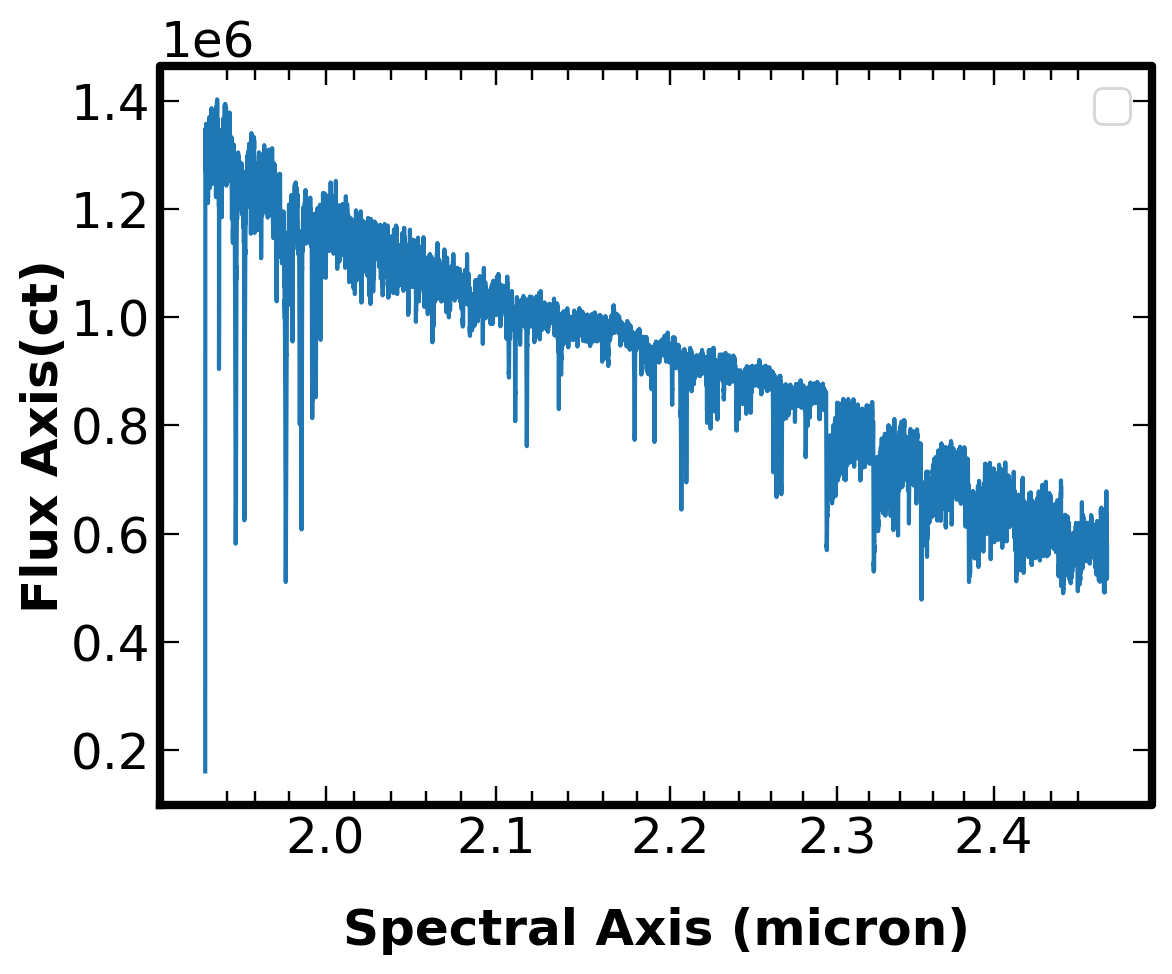

In [71]:
# fig,ax = plt.subplots(figsize=(20,10))

# plt.plot(spectrum.spectral_axis, spectrum.flux,label='Spectrum')
spectrum.plot()
# plt.plot(spectrum.spectral_axis, continuum_fitted,label='Continuum')

# plt.xlim(2,anon1_wavlen.values[-1])
# ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(spectrum.flux.unit))
plt.legend()

plt.show()

In [72]:
spec_normalized = spectrum / continuum_fitted

In [73]:
labels = [string.split('-')[0] for string in lines_str]
labels[0:5]

['Fe', 'Si', 'Mg', 'Al', 'Ca']

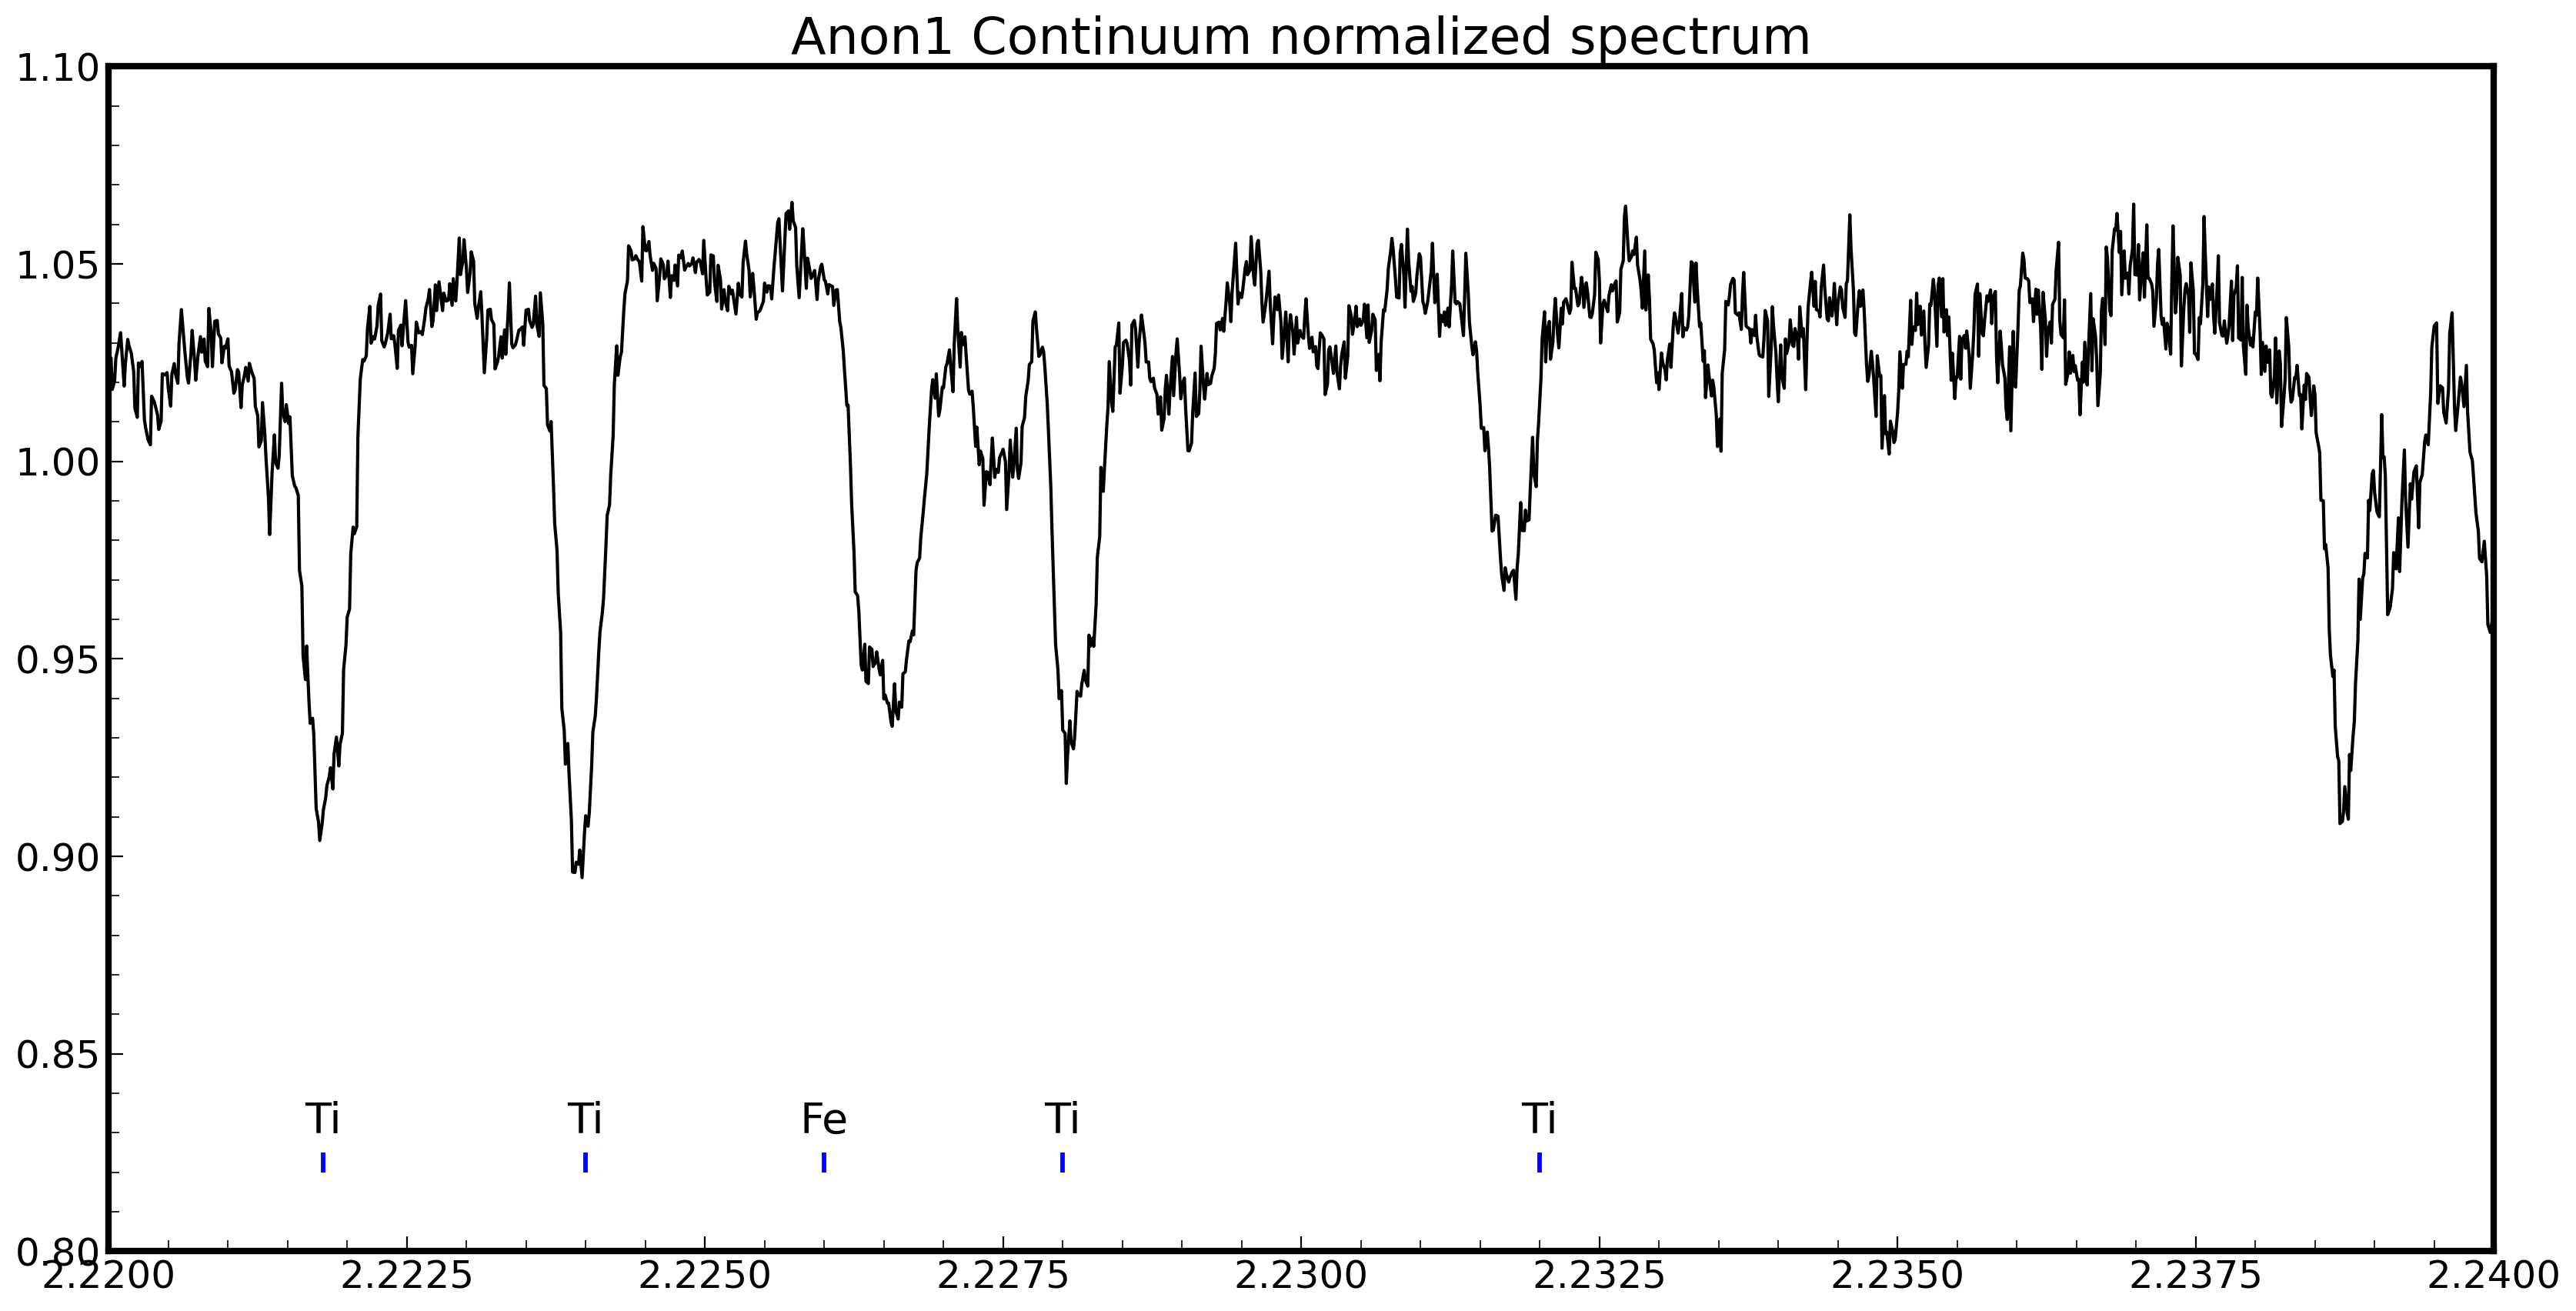

In [74]:
fig,ax = plt.subplots(figsize=(20,10)) 

ax.plot(spec_normalized.spectral_axis, spec_normalized.flux,c='black')
# ax.vlines(nir_dict['Ti-2.2218'],0.2,0.25,color='black')

ax.set_xlim(2.22,2.24)
ax.set_ylim(0.8,1.1)

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        ax.vlines(lines_wav[ii],0.82,0.825,color='blue')
        # ax.text(lines_wav[ii],0.26,s='line',ha='center')
        
text_y = 0.83
ax.text(nir_dict['Ti-2.2218'],text_y,'Ti',ha='center')
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')
ax.text(nir_dict['Fe-2.226'],text_y,'Fe',ha='center')
ax.text(nir_dict['Ti-2.228'],text_y,'Ti',ha='center')
ax.text(nir_dict['Ti-2.232'],text_y,'Ti',ha='center')

# Enable minor tick marks
ax.minorticks_on()
ax.set_title("Anon1 Continuum normalized spectrum")  

# ax.grid(True)
plt.show()